In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.utils import shuffle
from matplotlib.lines import Line2D

# Prep Data

In [810]:
def data_prep():
    molnames = ['urea','acrolein','alanine','sma','nitrophenol','urocanic','dmabn','thymine','o-hbdi']
    #idx = np.arange(0,15000)
    #idx = shuffle(idx,random_state=42)
    #idx=idx[:6000] #why?
    
    X=np.zeros((135000,253),dtype=float) 
    y_all = np.zeros((135000,5),dtype=float)
    
    start=0
    end=15000
    idx_names = np.zeros((135000),dtype=float)
    for i,m in enumerate(molnames):
        names = np.full(15000,i)
        idx_names[start:end] = np.copy(names)
        temp_data=np.load(f'/home/vvinod/2024/CheMFi/dataset/CheMFi_{m}.npz')['SCF'] # in hE #the property of interest can be changed here
        temp_X = np.load(f'/home/vvinod/2024/CheMFi/MFML/Reps/{m}_CM.npy')
        y_all[start:end,:] = temp_data
        X[start:end,:temp_X.shape[-1]] = temp_X
        #increment for next molecule
        start += 15000
        end += 15000
    y_new = np.zeros((5),dtype=object)
    
    X,idx_names = shuffle(X,idx_names,random_state=42)
    y_train = np.zeros((5),dtype=object) #STO3G first
    for i in range(5):
        y_all[:,i] = shuffle(y_all[:,i],random_state=42)
        y_new[i] = y_all[:,i]
        y_train[i] = y_new[i][:54000]
    
    X_train = X[:54000,:]
    X_val = X[54000:55000,:]
    y_val = y_new[-1][54000:55000] #TZVP
    X_test = X[55000:,:]
    y_test = y_new[-1][55000:] #TZVP
    
    y_val_SVP = y_new[3][54000:55000]
    y_val_631 = y_new[2][54000:55000]
    y_val_321 = y_new[1][54000:55000]
    y_val_STO = y_new[0][54000:55000]
    
    y_test_SVP = y_new[3][55000:]
    y_test_631 = y_new[2][55000:]
    y_test_321 = y_new[1][55000:]
    y_test_STO = y_new[0][55000:]
    
    np.save('raws/X_train_CM.npy',X_train)
    np.save('raws/X_test_CM.npy',X_test)
    np.save('raws/X_val_CM.npy',X_val)
    np.save('raws/energies.npy',y_train,allow_pickle=True)
    np.save('raws/y_test.npy',y_test)
    
    np.save('raws/y_lower_SVP.npy',y_test_SVP)
    np.save('raws/y_lower_631G.npy',y_test_631)
    np.save('raws/y_lower_321G.npy',y_test_321)
    np.save('raws/y_lower_STO3G.npy',y_test_STO)
    
    np.save('raws/y_val_SVP.npy',y_val_SVP)
    np.save('raws/y_val_631G.npy',y_val_631)
    np.save('raws/y_val_321G.npy',y_val_321)
    np.save('raws/y_val_STO3G.npy',y_val_STO)
    
    np.save('raws/y_val.npy',y_val)
    np.save('raws/idx_names.npy',idx_names)
    
    #save index file for MFML 
    indexes = np.zeros((5),dtype=object)
    temp = np.arange(0,54000)
    for i in range(5):
        indexes[i] = np.vstack([temp,temp]).T
    np.save('raws/indexes.npy',indexes,allow_pickle=True)
    

In [811]:
data_prep()

In [812]:
def data_distr(ax=None):
    ax = ax or plt.gca()
    full_idx = np.load('raws/idx_names.npy')
    train_idx = full_idx[:54000]
    val_idx = full_idx[54000:55000]
    test_idx = full_idx[55000:]
    
    colors = plt.cm.binary(np.linspace(0,1,4))[1:]
    
    ax.hist([train_idx,test_idx,val_idx],bins=9,stacked=False,log=True,color=colors)
    ax.legend(['train','test','val'],bbox_to_anchor=(1,1))
    ax.set_xticks([0,1,2,3,4,5,6,7,8],
               ['urea','acrolein','alanine',
                'sma','2-nitrophenol','urocanic',
                'dmabn','thymine','o-hbdi'],
               rotation=45)
    ax.set_ylabel('Number of geometries')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


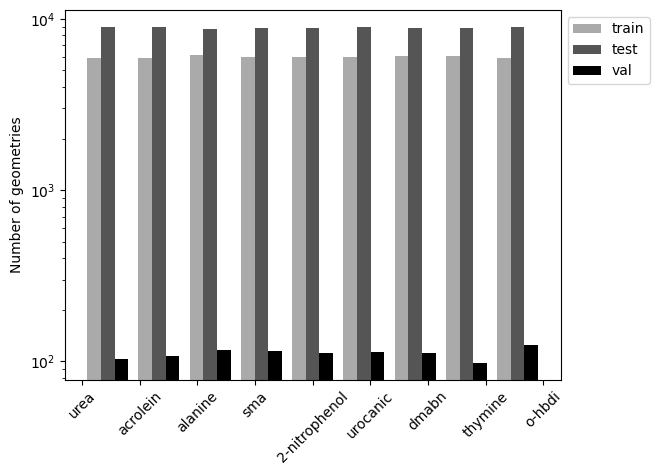

In [813]:
data_distr()
plt.savefig('plots/distr_hist.eps',format='eps',bbox_inches='tight',dpi=150.0)

# $\Delta$ ML

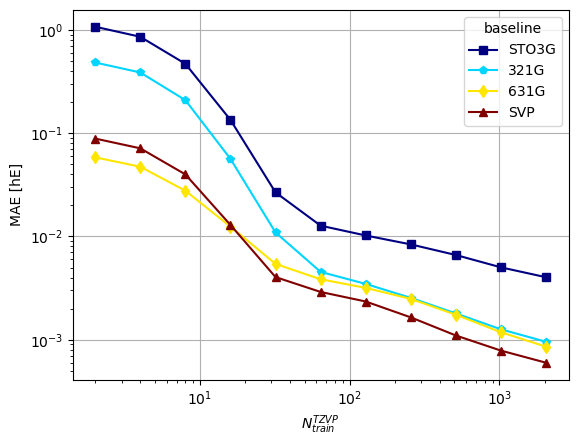

In [2]:
def delMLLCs(ax=None):
    ax = ax or plt.gca()
    fids = ['STO3G','321G','631G','SVP']
    delMLs = np.zeros((4),dtype=object)
    
    colors=plt.cm.jet(np.linspace(0,1,4))#[:-1]
    markers = ['s','p','d','^']
    
    for i in range(4):
        delMLs[i] = np.load(f'outs/delML_{fids[i]}_mae.npy')
        n = 2**np.arange(1,1+delMLs[i].shape[0])
        ax.loglog(n,delMLs[i],label=f'{fids[i]}',marker=markers[i],color=colors[i])
    ax.legend(title='baseline')
    ax.set_ylabel('MAE [hE]')
    ax.set_xlabel('$N_{train}^{TZVP}$')
    ax.grid()
    #ax.set_title('Comparing Different Baselines\nFor $\Delta$-ML')
delMLLCs()
#plt.savefig('plots/delta_LC_comparison.eps',format='eps',bbox_inches='tight',dpi=150.0)

Key take-away:
   * the closer the fidelity to target fidelity, the lower the error
   * difference of almost an order of magnitude between STO3G and def2-SVP

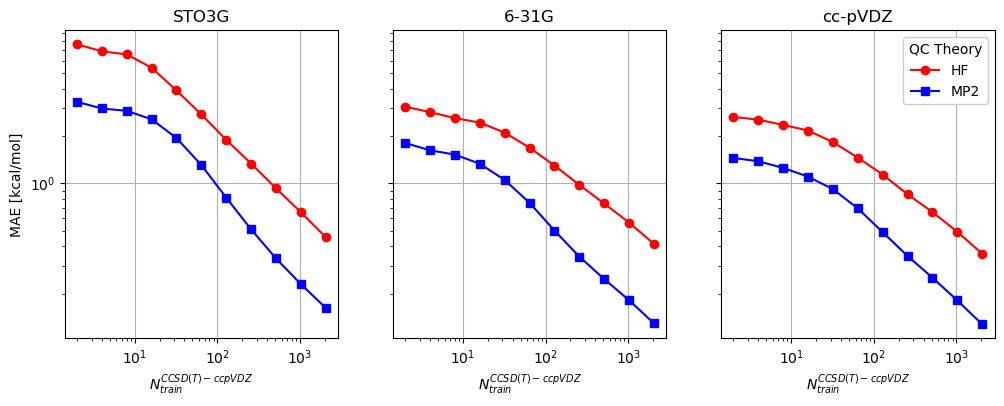

In [3]:
def QM7b_delta_ML():
    sto3g = np.load('QM7bRaws/DelMAE_sto3g.npy',allow_pickle=True)
    g631 = np.load('QM7bRaws/DelMAE_631g.npy',allow_pickle=True)
    pvdz = np.load('QM7bRaws/DelMAE_ccpvdz.npy',allow_pickle=True)
    
    n = 2**np.arange(1,12)
    
    color=['r','b']
    fig,ax = plt.subplots(1,3,figsize=(12,4),sharey=True)
    
    ax[0].set_title('STO3G')
    ax[1].set_title('6-31G')
    ax[2].set_title('cc-pVDZ')
    
    ax[0].loglog(n,sto3g[0],color=color[0],marker='o',label='HF')
    ax[0].loglog(n,sto3g[1],color=color[1],marker='s',label='MP2')
   
    ax[0].set_ylabel('MAE [kcal/mol]')
    
    ax[1].loglog(n,g631[0],color=color[0],marker='o',label='HF')
    ax[1].loglog(n,g631[1],color=color[1],marker='s',label='MP2')
    
    ax[2].loglog(n,pvdz[0],color=color[0],marker='o',label='HF')
    ax[2].loglog(n,pvdz[1],color=color[1],marker='s',label='MP2')
    ax[2].legend(title='QC Theory',framealpha=1.0)
    for i in range(3):
        ax[i].grid()
        ax[i].set_xlabel('$N_{train}^{CCSD(T)-ccpVDZ}$')
    
QM7b_delta_ML()    
#plt.savefig('plots/DelML_QM7b.eps',format='eps',bbox_inches='tight',dpi=150.0)

# MFML

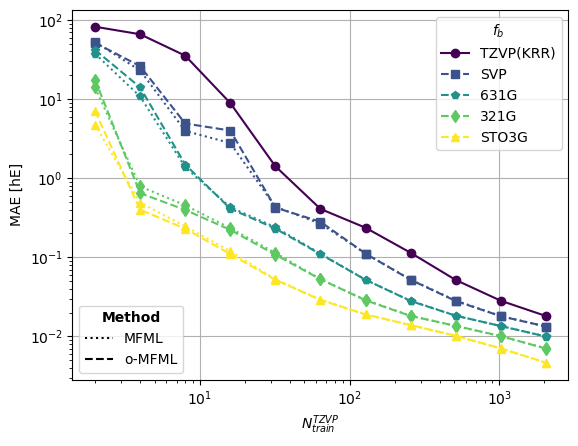

In [4]:
def MFML_LC(ax=None):
    ax = ax or plt.gca()
    def_mae = np.load('outs/defaultMAEs.npy',allow_pickle=True)
    OLS_mae = np.load('outs/OLSMAEs.npy',allow_pickle=True)
    n = 2**np.arange(1,1+def_mae[1].shape[0])
    fids = ['STO3G','321G','631G','SVP','TZVP']
    
    colors=plt.cm.viridis(np.linspace(0,1,5))#[:-1]
    markers = ['o','s','p','d','^']
    
    ax.loglog(n,def_mae[0],marker=markers[0],linestyle='-',label='TZVP(KRR)',color=colors[0]) 
    
    for i in range(1,5):
        ax.loglog(n,def_mae[i],marker=markers[i],linestyle=':',color=colors[i])
        ax.loglog(n,OLS_mae[i],marker=markers[i],linestyle='--',label=fids[4-i],color=colors[i])
    ax.set_ylabel('MAE [hE]')
    ax.set_xlabel('$N_{train}^{TZVP}$')
    color_legend = ax.legend(title='$f_b$',loc='upper right')
    
    style_lines = [Line2D([0], [0], color='black', linestyle=':', label='MFML'),
                   Line2D([0], [0], color='black', linestyle='--', label='o-MFML')
                  ]
    style_legend = ax.legend(handles=style_lines, title='Method', loc='lower left',title_fontproperties={'weight': 'bold'})
    ax.add_artist(color_legend)
    ax.grid()
MFML_LC()
#plt.savefig('plots/MFML_LCs.eps',format='eps',bbox_inches='tight',dpi=150.0)

Key take-away:
* MFML and o-MFML perform similarly

# MF$\Delta$ML

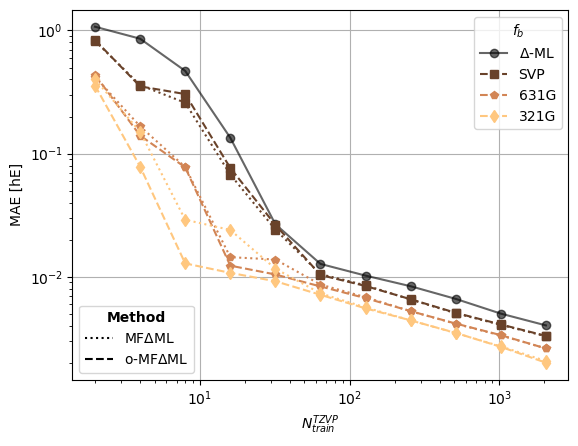

In [5]:
def MFDeltaML_LC(ax=None):
    ax = ax or plt.gca()
    def_mae = np.load('outs/Delta_defaultMAEs_STO3G.npy',allow_pickle=True)[1:]
    OLS_mae = np.load('outs/Delta_OLSMAEs_STO3G.npy',allow_pickle=True)[1:]
    delsto = np.load('outs/delML_STO3G_mae.npy')
    n = 2**np.arange(1,1+def_mae[1].shape[0])
    
    fids = ['STO3G','321G','631G','SVP','TZVP']
    
    colors=plt.cm.copper(np.linspace(0,1,4))#[:-1]
    markers = ['s','p','d','^']
    
    ax.loglog(n,delsto,marker='o',linestyle='-',label='$\Delta$-ML',color=colors[0],alpha=0.6)
    
    for i in range(3):
        ax.loglog(n,def_mae[i],marker=markers[i],color=colors[i+1],linestyle=':')
        ax.loglog(n,OLS_mae[i],marker=markers[i],color=colors[i+1],linestyle='--',label=fids[3-i])
    ax.set_ylabel('MAE [hE]')
    ax.set_xlabel('$N_{train}^{TZVP}$')
    color_legend = ax.legend(title='$f_b$',loc='upper right')
    
    style_lines = [Line2D([0], [0], color='black', linestyle=':', label='MF$\Delta$ML'),
                   Line2D([0], [0], color='black', linestyle='--', label='o-MF$\Delta$ML')
                  ]
    style_legend = ax.legend(handles=style_lines, title='Method', loc='lower left',title_fontproperties={'weight': 'bold'})
    ax.add_artist(color_legend)
    #ax.set_title('Learning Curves\nMF$\Delta$-ML and o-MF$\Delta$ML')
    ax.grid()
MFDeltaML_LC()
#plt.savefig('plots/MFDeltaML_LCs.eps',format='eps',bbox_inches='tight',dpi=150.0)

# Time vs MAE

In [6]:
def return_train_times():
    all_times = np.zeros((9,5),dtype=float)
    molnames = ['urea','acrolein','alanine','sma',
                'nitrophenol','urocanic',
                'dmabn','thymine','o-hbdi']
    for i in range(9): #loop over molecules in CheMFi
        all_times[i,:] = np.load(f'../CheMFi/dataset/CheMFi_{molnames[i]}.npz',
                                 allow_pickle=True)['t']
    return all_times

def time_cost(n_trains=None, all_times=None):
    if type(n_trains)==type(None):
        n_trains = np.asarray([32, 16, 8, 4, 2])
    if type(all_times)==type(None):
        all_times = return_train_times()
    n_trains=np.asarray(n_trains)
    train_idx = np.load('raws/idx_names.npy')
    train_idx = train_idx.astype(dtype=int) 
    train_idx = train_idx[:n_trains.max()]
    
    train_times = all_times[train_idx,:]

    train_cost = 0
    for i in range(5):
        train_cost += train_times[:n_trains[i],i].sum()
    
    return train_cost

In [9]:
def combined_time_comparison_plot(ax=None, colors=None):
    ax = ax or plt.gca()
    
    if type(colors)==type(None):
        colors = plt.cm.viridis(np.linspace(0,1,10))
    train_idx = np.load('raws/idx_names.npy')
    train_idx = train_idx.astype(dtype=int) 
    test_idx = np.copy(train_idx[55000:])
    val_idx = np.copy(train_idx[54000:55000])
    
    all_times = return_train_times()
    
    val_time = all_times[val_idx,-1].sum()/60.0
    test_sto_time = all_times[test_idx,0].sum()/60.0 #*12.5 #for hypothetical 1 million geometries in test set

    
    
    #default MFML - only sto3g
    #OLS MFML - only sto3g
    sf_mae = np.load('outs/defaultMAEs.npy',allow_pickle=True)[0]
    def_mae = np.load('outs/defaultMAEs.npy',allow_pickle=True)[-1]
    OLS_mae = np.load('outs/OLSMAEs.npy',allow_pickle=True)[-1]
    
    
    #delta MFML versions
    del_def_mae = np.load('outs/Delta_defaultMAEs_STO3G.npy',allow_pickle=True)[-1]
    del_OLS_mae = np.load('outs/Delta_OLSMAEs_STO3G.npy',allow_pickle=True)[-1]
    delsto = np.load('outs/delML_STO3G_mae.npy')
    
    sf_time = []
    del_ML_time = []
    MFML_time = []
    del_MFML_time = []
    for i in range(1,12):
        sf_time.append(time_cost(n_trains=[0,0,0,0,2**(i)], all_times=all_times))
        del_ML_time.append(time_cost(n_trains=[2**(i),0,0,0,2**(i)], all_times=all_times))
        MFML_time.append(time_cost(n_trains=[2**(i+4),2**(i+3),2**(i+2),2**(i+1),2**(i)], all_times=all_times))
        del_MFML_time.append(time_cost(n_trains=[2**(i+3),2**(i+3),2**(i+2),2**(i+1),2**(i)], all_times=all_times))
    sf_time = np.asarray(sf_time)/60.0
    del_ML_time = np.asarray(del_ML_time)/60.0
    MFML_time = np.asarray(MFML_time)/60.0
    del_MFML_time = np.asarray(del_MFML_time)/60.0
    
    ax.loglog(sf_time,sf_mae,marker='o',
              label='KRR(TZVP)',color=colors[0],linestyle=':')
    ax.loglog(MFML_time, def_mae, marker='s',
              label='MFML(STO3G)',color=colors[1],linestyle='-')
    ax.loglog(MFML_time+val_time, OLS_mae, marker='d',
              label='o-MFML(STO3G)',color=colors[2],linestyle=':')
    
    ax.loglog(del_ML_time+test_sto_time, delsto, marker='+',#
              label='$\Delta$-ML(STO3G)', color = colors[3],linestyle=':')
    ax.loglog(del_MFML_time+test_sto_time, del_def_mae,marker='^',#
              label='MF$\Delta_{STO3G}$ML(321G)', color = colors[4],linestyle=':')
    ax.loglog(del_MFML_time+test_sto_time+val_time, del_OLS_mae,marker='d',
              label='o-MF$\Delta_{STO3G}$ML(321G)', color = colors[5],linestyle=':')
    
    ax.legend(ncol=1,framealpha=1.0,fontsize=8.5)
    ax.set_xlabel('$\mathrm{T_{train-data}}$ [min]')
    ax.set_ylabel('MAE [hE]')
    ax.grid()

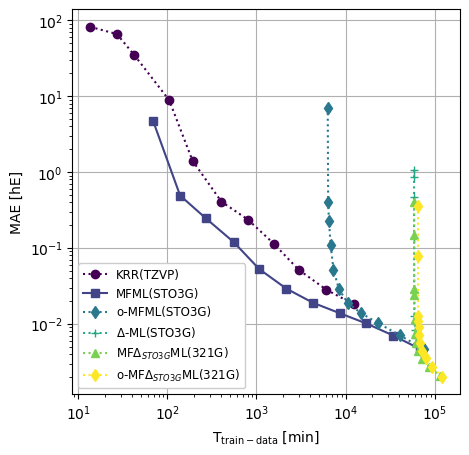

In [10]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
#viridis, tab20b, tab20
combined_time_comparison_plot(colors = plt.cm.viridis(np.linspace(0,1,6)),ax=ax)
#plt.savefig('plots/hypoothetical_time.eps',format='eps',bbox_inches='tight',dpi=150.0)
#plt.xlim(5e3,5e4)

# Predicted-baseline-$\Delta$-ML

0.018113567710767133
0.004028331286273114
0.0046490156867888795


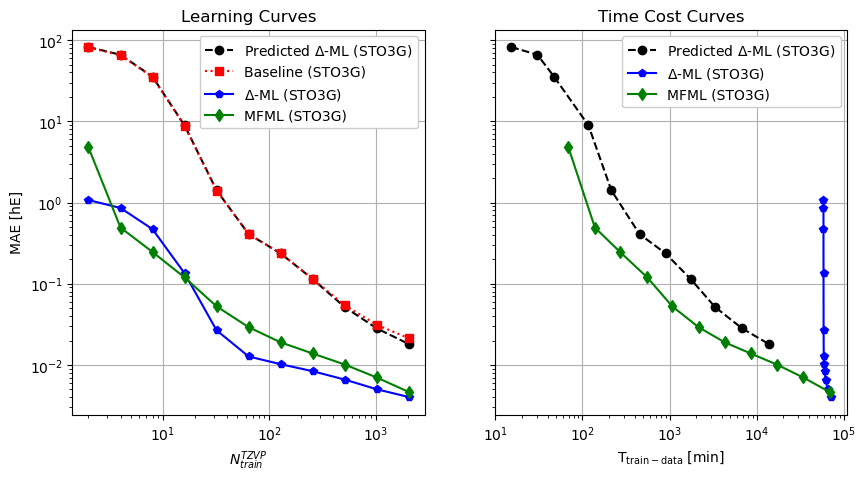

In [12]:
def predictedDelMLcomp(ax=None):
    #calculate times
    train_idx = np.load('raws/idx_names.npy')
    train_idx = train_idx.astype(dtype=int) 
    test_idx = np.copy(train_idx[55000:])
    val_idx = np.copy(train_idx[54000:55000])
    all_times = return_train_times()
    test_sto_time = all_times[test_idx,0].sum()/60.0
    del_ML_time = []
    MFML_time = []

    for i in range(1,12):
        del_ML_time.append(time_cost(n_trains=[2**(i),0,0,0,2**(i)], all_times=all_times))
        MFML_time.append(time_cost(n_trains=[2**(i+4),2**(i+3),2**(i+2),2**(i+1),2**(i)], all_times=all_times))
    del_ML_time = np.asarray(del_ML_time)/60.0
    MFML_time = np.asarray(MFML_time)/60.0
    
    ###load maes
    m = np.load('outs/predictedbase_delML_STO3G_mae.npy')
    print(m[-1])
    b = np.load('outs/predictedbase_delML_baseline_mae.npy')
    sto3g = np.load('outs/delML_STO3G_mae.npy')
    print(sto3g[-1])
    MFML_sto3g = np.load('outs/defaultMAEs.npy',allow_pickle=True)[-1]
    print(MFML_sto3g[-1])
    colors = ['k','r','b','g']#plt.cm.jet(np.linspace(0,1,4))
    fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True)

    ax[0].set_title('Learning Curves')
    ax[1].set_title('Time Cost Curves')

    ax[0].loglog(2**np.arange(1,12),m,marker='o',label='Predicted $\Delta$-ML (STO3G)',linestyle='--',color=colors[0])
    ax[0].loglog(2**np.arange(1,12),b,marker='s',label='Baseline (STO3G)', linestyle=':',color=colors[1])
    ax[0].loglog(2**np.arange(1,12),sto3g,marker='p',label='$\Delta$-ML (STO3G)',color=colors[2])
    ax[0].loglog(2**np.arange(1,12),MFML_sto3g,marker='d', label='MFML (STO3G)',color=colors[3])
    ax[0].legend(framealpha=1.0)
    ax[0].grid()

    ax[1].loglog(del_ML_time,m,marker='o',label='Predicted $\Delta$-ML (STO3G)',linestyle='--',color=colors[0])
    ax[1].loglog(del_ML_time+test_sto_time,sto3g,marker='p',label='$\Delta$-ML (STO3G)',color=colors[2])
    ax[1].loglog(MFML_time,MFML_sto3g,marker='d', label='MFML (STO3G)',color=colors[3])
    ax[1].grid()
    ax[1].legend(framealpha=1.0)
    ax[0].set_ylabel('MAE [hE]')
    ax[0].set_xlabel('$N_{train}^{TZVP}$')
    ax[1].set_xlabel('$\mathrm{T_{train-data}}$ [min]')
predictedDelMLcomp()
#plt.savefig('plots/predicteddeltaML.eps',format='eps',bbox_inches='tight', dpi=150.0)